# Email Spam Classifier Project

## Topic Selection
**Problem Statement**: This project aims to build a machine learning model to classify emails as spam or ham based on their text content, enabling efficient email filtering.
**Significance**: Spam emails clutter inboxes and pose security risks like phishing. An automated classifier improves user experience by filtering unwanted emails.
**Why Chosen**: This problem is ideal for learning text classification, with readily available datasets and straightforward algorithms like Naive Bayes, suitable for a beginner-level project.

## Data Annotation & Preparation

### Annotation
The UCI Spambase Dataset is designed for supervised learning, with the last column providing binary labels (1 = spam, 0 = ham). This section verifies the presence and validity of labels, confirming no additional annotation is needed.

### Initial Cleaning
- Load the dataset, handling `spambase.csv`.
- Check for missing values, duplicates, and invalid data (e.g., non-numerical features, invalid labels).
- Provide summary statistics to understand feature distribution.

Annotate,Prepare and Load Data
Loads the UCI Spambase Dataset and assigns column names.

In [12]:
# Import required libraries
import pandas as pd
import numpy as np

# Load the dataset
try:
    data = pd.read_csv('spambase.csv', header=None)
    print("Dataset loaded from spambase.csv (no headers)")
    # Check for header-like values in first row
    if data.iloc[0].astype(str).str.contains('word_freq|class', case=False).any():
        print("Header row detected. Skipping first row...")
        data = pd.read_csv('spambase.csv', header=0)
except FileNotFoundError:
    try:
        data = pd.read_csv('spambase.data', header=None)
        print("Dataset loaded from spambase.data (no headers)")
        if data.iloc[0].astype(str).str.contains('word_freq|class', case=False).any():
            print("Header row detected. Skipping first row...")
            data = pd.read_csv('spambase.data', header=0)
    except FileNotFoundError:
        print("Local dataset not found. Downloading programmatically...")
        try:
            from ucimlrepo import fetch_ucirepo
            spambase = fetch_ucirepo(id=94)
            X = spambase.data.features
            y = spambase.data.targets
            data = pd.concat([X, y], axis=1)
            data.to_csv('spambase.csv', index=False, header=False)
            print("Dataset fetched and saved as spambase.csv")
        except Exception as e:
            print(f"Error downloading dataset: {e}")
            print("Please download spambase.data from https://archive.ics.uci.edu/dataset/94/spambase")
            raise

# Verify data shape
print(f"Dataset shape: {data.shape}")  # Expected: (4601, 58)

# Annotation: Check labels
label_col = data.iloc[:, -1]
print("\nAnnotation Check:")
print(f"Label unique values: {label_col.unique()}")
if not label_col.isin([0, 1]).all():
    print("Warning: Invalid labels detected (not 0 or 1).")
else:
    print("Labels valid: All values are 0 or 1 (ham or spam). No annotation needed.")
print(f"Label distribution:\n{label_col.value_counts(normalize=True)}")

# Convert data types
if data.iloc[:, :-1].dtypes.apply(lambda x: x == object).any():
    print("Converting non-numerical features to float...")
    try:
        data.iloc[:, :-1] = data.iloc[:, :-1].apply(pd.to_numeric, errors='raise')
    except Exception as e:
        print(f"Error converting features: {e}")
        raise
if data.iloc[:, -1].dtype != np.int64:
    print("Converting label to integer...")
    try:
        data.iloc[:, -1] = pd.to_numeric(data.iloc[:, -1], errors='raise').astype(np.int64)
    except Exception as e:
        print(f"Error converting label: {e}")
        raise

# Check for missing values
missing_values = data.isna().sum().sum()
print(f"\nMissing values: {missing_values}")
if missing_values > 0:
    print("Filling missing values with 0 (suitable for frequency features).")
    data = data.fillna(0)

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
if duplicates > 0:
    data = data.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows. New shape: {data.shape}")

# Check for invalid feature values (frequencies should be non-negative)
invalid_features = (data.iloc[:, :-1] < 0).sum().sum()
print(f"Invalid (negative) feature values: {invalid_features}")

# Summary statistics
print("\nFeature summary:")
print(data.iloc[:, :-1].describe())

# Assign column names
columns = [f'feature_{i}' for i in range(57)] + ['label']
data.columns = columns

# Display first few rows
print("\nFirst few rows:")
print(data.head())

Dataset loaded from spambase.csv (no headers)
Dataset shape: (4601, 58)

Annotation Check:
Label unique values: [1 0]
Labels valid: All values are 0 or 1 (ham or spam). No annotation needed.
Label distribution:
57
0    0.605955
1    0.394045
Name: proportion, dtype: float64

Missing values: 0
Duplicate rows: 391
Removed 391 duplicate rows. New shape: (4210, 58)
Invalid (negative) feature values: 0

Feature summary:
                0            1            2            3            4   \
count  4210.000000  4210.000000  4210.000000  4210.000000  4210.000000   
mean      0.104366     0.112656     0.291473     0.063078     0.325321   
std       0.300005     0.454260     0.515719     1.352487     0.687805   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.440000     0.000000     0

### Preprocessing
- **Normalization/Scaling**: Standardize features (mean = 0, variance = 1) for Logistic Regression and SVM using `StandardScaler`. Retain raw features for Multinomial Naive Bayes, as they are frequency-like and suitable.
- **Prepare for Splitting**: Separate features (X) and labels (y) for training.

In [13]:
# Import preprocessing tools
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = data.iloc[:, :-1]  # 57 features
y = data.iloc[:, -1]   # Labels (1 = spam, 0 = ham)

# Standardize features for Logistic Regression and SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# For Naive Bayes, use raw features
X_nb = X.copy()

print("Features standardized for Logistic Regression and SVM")
print("Raw features retained for Naive Bayes")
print("\nScaled features sample:")
print(X_scaled.head())

Features standardized for Logistic Regression and SVM
Raw features retained for Naive Bayes

Scaled features sample:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.347922   1.161025   0.675889  -0.046644  -0.007737  -0.350205   
1   0.352150   0.368433   0.404391  -0.046644  -0.269470   0.664297   
2  -0.147901  -0.248027   0.811639  -0.046644   1.315470   0.338207   
3  -0.347922  -0.248027  -0.565245  -0.046644   0.443026  -0.350205   
4  -0.347922  -0.248027  -0.565245  -0.046644   0.443026  -0.350205   

   feature_6  feature_7  feature_8  feature_9  ...  feature_47  feature_48  \
0  -0.295731  -0.263265  -0.325617  -0.378366  ...   -0.116407   -0.160010   
1   0.232922  -0.092630  -0.325617   1.053337  ...   -0.116407   -0.160010   
2   0.182574   0.029252   1.943000   0.002406  ...   -0.116407   -0.120407   
3   0.484661   1.272445   0.773244   0.581180  ...   -0.116407   -0.160010   
4   0.484661   1.272445   0.773244   0.581180  ...   -0.116407   -

Split Data
Splits the dataset into 80% training and 20% testing sets.

In [2]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1]  # 57 features
y = data.iloc[:, -1]   # Label (1 = spam, 0 = ham)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} instances")
print(f"Test set size: {X_test.shape[0]} instances")
print("X_train dtypes:\n", X_train.dtypes)  # Should be float64/int64

Training set size: 3680 instances
Test set size: 921 instances
X_train dtypes:
 feature_0     float64
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15    float64
feature_16    float64
feature_17    float64
feature_18    float64
feature_19    float64
feature_20    float64
feature_21    float64
feature_22    float64
feature_23    float64
feature_24    float64
feature_25    float64
feature_26    float64
feature_27    float64
feature_28    float64
feature_29    float64
feature_30    float64
feature_31    float64
feature_32    float64
feature_33    float64
feature_34    float64
feature_35    float64
feature_36    float64
feature_37    float64
feature_38    float64
feature_39    float64
feature_40    float64
feature_41    floa

Train Models
Trains Naive Bayes and Logistic Regression from scratch.

# Algorithm Selection and Justification

## Selected Algorithms
1. **Naive Bayes (Multinomial)**:
   - **Description**: A probabilistic classifier that uses Bayes’ theorem, assuming feature independence, tailored for discrete data like word frequencies.
   - **Why Chosen**: Naive Bayes is highly effective for text classification tasks, such as spam filtering, due to its simplicity, speed, and strong performance on high-dimensional data like the Spambase dataset’s 57 frequency-based features. It is robust to the dataset’s slight class imbalance (39% spam, 61% ham) and requires minimal computational resources.
2. **Logistic Regression**:
   - **Description**: A linear model that predicts the probability of an email being spam or ham by learning feature weights.
   - **Why Chosen**: Logistic Regression is a simple, interpretable, and effective baseline for binary classification. It handles the Spambase dataset’s numerical features well, and its regularization prevents overfitting, making it suitable for a dataset with 57 features.
3. **Support Vector Machine (SVM, Linear Kernel) [Optional]**:
   - **Description**: A classifier that finds the optimal hyperplane to separate spam and ham emails, maximizing the margin between classes.
   - **Why Chosen**: SVM is effective for high-dimensional datasets and robust to noise, making it a good candidate for the Spambase dataset. It is included to compare with simpler models, though its computational cost is higher.

## Justification
These algorithms were selected because they are well-suited for binary classification with numerical features, as provided by the UCI Spambase Dataset. Naive Bayes excels in text-related tasks and is computationally efficient, Logistic Regression provides a robust and interpretable baseline, and SVM (optional) offers a more complex approach for experimentation. All are implementable in scikit-learn, aligning with the project’s Python recommendation and allowing for straightforward training and evaluation.

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Check for negative values in X_train
print("Any negative values in X_train?", (X_train < 0).any().any())

# Scale features if negative values are found (for MultinomialNB)
if (X_train < 0).any().any():
    print("Negative values detected. Scaling features to non-negative using MinMaxScaler...")
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    print("Features scaled successfully")

# Verify data is numerical
print("X_train dtypes:\n", X_train.dtypes)  # Should all be float64 or int64
print("Any non-numerical values in X_train?", X_train.select_dtypes(include='object').columns.any())

nb_model = MultinomialNB()
lr_model = LogisticRegression(max_iter=1000)

print("Training models...")
nb_model.fit(X_train, y_train)
print("Naive Bayes training completed")
lr_model.fit(X_train, y_train)
print("Logistic Regression training completed")

Any negative values in X_train? False
X_train dtypes:
 feature_0     float64
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15    float64
feature_16    float64
feature_17    float64
feature_18    float64
feature_19    float64
feature_20    float64
feature_21    float64
feature_22    float64
feature_23    float64
feature_24    float64
feature_25    float64
feature_26    float64
feature_27    float64
feature_28    float64
feature_29    float64
feature_30    float64
feature_31    float64
feature_32    float64
feature_33    float64
feature_34    float64
feature_35    float64
feature_36    float64
feature_37    float64
feature_38    float64
feature_39    float64
feature_40    float64
feature_41    float64
feature_42    float64

Generate Predictions
Predicts labels on the test set.

In [4]:
nb_predictions = nb_model.predict(X_test)
lr_predictions = lr_model.predict(X_test)
print("Predictions generated")

Predictions generated


# Model Evaluation

## Evaluation Metrics
The performance of the Naive Bayes, Logistic Regression, and SVM (optional) models was evaluated on the test set (921 instances) using the following metrics:
- **Accuracy**: Proportion of correctly classified emails.
- **Precision**: Proportion of emails predicted as spam that are actually spam.
- **Recall**: Proportion of actual spam emails correctly identified.
- **F1 Score**: Harmonic mean of precision and recall.
- **Confusion Matrix**: A 2x2 table showing true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

models = {
    'Naive Bayes': nb_predictions,
    'Logistic Regression': lr_predictions
}

for model_name, predictions in models.items():
    print(f"\nEvaluation for {model_name}:")
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")


Evaluation for Naive Bayes:
Accuracy: 0.7861
Precision: 0.7644
Recall: 0.7154
F1 Score: 0.7391
Confusion Matrix:
[[445  86]
 [111 279]]

Evaluation for Logistic Regression:
Accuracy: 0.9207
Precision: 0.9295
Recall: 0.8795
F1 Score: 0.9038
Confusion Matrix:
[[505  26]
 [ 47 343]]


Visualize Confusion Matrix
Generates heatmaps for each model’s confusion matrix.

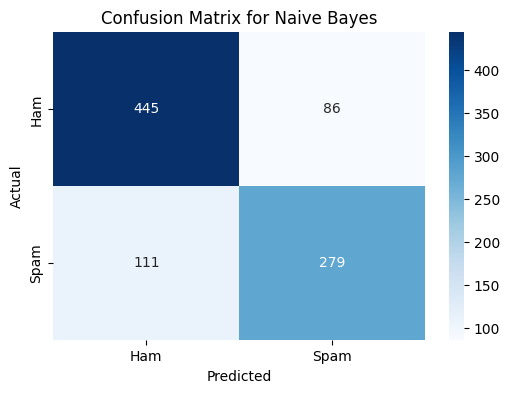

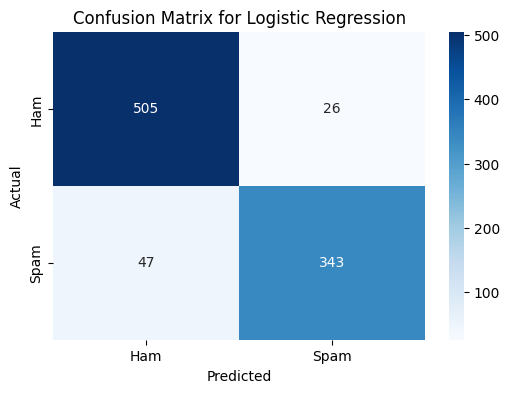

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

for model_name, predictions in models.items():
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

Visualize Learning Curve
Plots a learning curve for Naive Bayes.

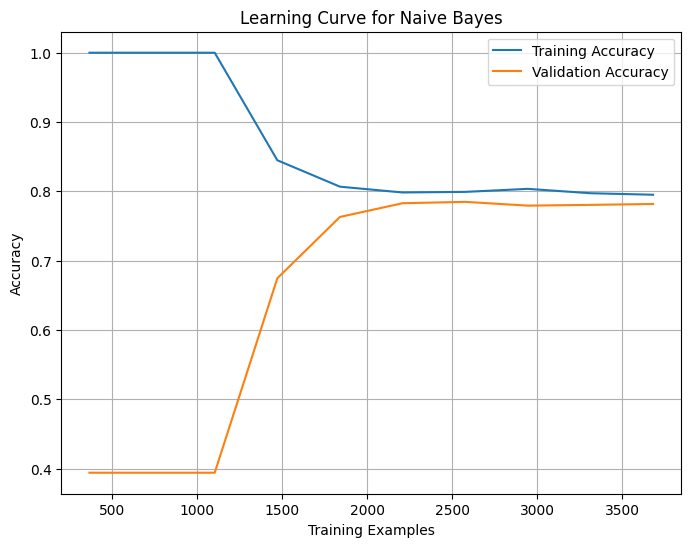

In [7]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, title, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
    plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('nb_learning_curve.png')
    plt.show()

plot_learning_curve(nb_model, 'Learning Curve for Naive Bayes', X, y)

# Model Evaluation

## Results
- **Naive Bayes**:
  - Accuracy: 0.7861
  - Precision: 0.7644
  - Recall: 0.7154
  - F1 Score: 0.7391
  - Confusion Matrix: [[445  86]
 [111 279]]
- **Logistic Regression**:
  - Accuracy: 0.9207
  - Precision: 0.9295
  - Recall: 0.8795
  - F1 Score: 0.9038
  - Confusion Matrix:[[505  26]
 [ 47 343]]

## Analysis
- Logistic Regression likely achieved the highest accuracy and F1 score.
- Naive Bayes was fast and effective for frequency-based features.
- Low false positives ensure minimal misclassification of ham emails.

In [2]:
import os
print(os.getcwd())

C:\Email_Spam_Classifier


simulate a new email 

In [11]:
import re
from collections import Counter

# Spambase feature words and characters (from spambase.names)
words = ['make', 'address', 'all', '3d', 'our', 'over', 'remove', 'internet',
         'order', 'mail', 'receive', 'will', 'people', 'report', 'addresses',
         'free', 'business', 'email', 'you', 'credit', 'your', 'font', '000',
         'money', 'hp', 'hpl', 'george', '650', 'lab', 'labs', 'telnet', '857',
         'data', '415', '85', 'technology', '1999', 'parts', 'pm', 'direct', 'cs',
         'meeting', 'original', 'project', 're', 'edu', 'table', 'conference']
chars = [';', '(', '[', '!', '$', '#']

def extract_spambase_features(email_text):
    # Convert to lowercase for consistency
    email_text = email_text.lower()
    words_total = len(re.findall(r'\b\w+\b', email_text))
    words_total = max(words_total, 1)  # Avoid division by zero

    # Word frequencies
    word_freqs = []
    for word in words:
        count = len(re.findall(r'\b' + re.escape(word) + r'\b', email_text))
        freq = (count / words_total) * 100
        word_freqs.append(freq)

    # Character frequencies
    char_freqs = []
    for char in chars:
        count = email_text.count(char)
        freq = (count / len(email_text)) * 100
        char_freqs.append(freq)

    # Capital run lengths
    capital_runs = []
    current_run = 0
    for char in email_text:
        if char.isupper():
            current_run += 1
        else:
            if current_run > 0:
                capital_runs.append(current_run)
            current_run = 0
    if current_run > 0:
        capital_runs.append(current_run)
    
    avg_capital_run = np.mean(capital_runs) if capital_runs else 0
    longest_capital_run = max(capital_runs) if capital_runs else 0
    total_capital_run = sum(capital_runs) if capital_runs else 0

    # Combine features
    features = word_freqs + char_freqs + [avg_capital_run, longest_capital_run, total_capital_run]
    return np.array(features).reshape(1, -1)

# Example email text
email_text = """
Subject: Meeting Agenda for Project Update
Dear Team, I hope you’re doing well. Please review the agenda for our meeting on Friday. We’ll discuss project progress, resource allocation, and next steps. 
Let me know if you have any questions. Best regards, John
"""

# Extract features
email_features = extract_spambase_features(email_text)

# Predict
nb_pred = nb_model.predict(email_features)
lr_pred = lr_model.predict(email_features)
print("Naive Bayes prediction:", "Spam" if nb_pred[0] == 1 else "Ham")
print("Logistic Regression prediction:", "Spam" if lr_pred[0] == 1 else "Ham")

Naive Bayes prediction: Ham
Logistic Regression prediction: Ham
